# **Medical Cost Analysis**.
A project for the Global AI Hub International ML Bootcamp.

In this project, we will be trying to develop an end-to-end data science application using the
dataset given above. The aim of the project is to estimate the approximate cost of a person's health insurance based on the following variables.

* age: age of primary beneficiary 
* sex: insurance contractor gender, female, male 
* bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9 
* children: Number of children covered by health insurance / Number of dependents
* smoker: Smoking
* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

What we are trying to predict.

* charges: Individual medical costs billed by health insurance.

In [970]:
!pip install -q category_encoders


In [971]:
#Data Analysis
import pandas as pd
import numpy as np

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Data Preprocessing
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats.mstats import winsorize

#Regression Models
from sklearn.linear_model import LinearRegression,Lasso,Ridge,SGDRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor

#Evaluation
from sklearn.model_selection import (train_test_split,
                                     learning_curve,
                                     cross_val_score,
                                     KFold,
                                     GridSearchCV,
                                     )
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [972]:
#Set theme for plots.
sns.set_theme(style='whitegrid')

# **Prepare data**

## **Import**

We import the data from the csv using pandas.

In [973]:
def wrangle(file_location):
  df = pd.read_csv(file_location)
  return df

In [974]:
#Read data to DataFrame
df = wrangle('/content/drive/MyDrive/globalAiproject/insurance.csv')

## **Explore**

We perform Exploratory Data Analysis to get a feel of the kind of data we are going to be working with.

In [975]:
print("df shape:", df.shape)
df.head()

df shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [976]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


*   We have no null values in our data.
*   We have 1338 observations and 7 features

In [977]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [978]:
# Drop Duplicates
df.drop_duplicates(inplace=True)

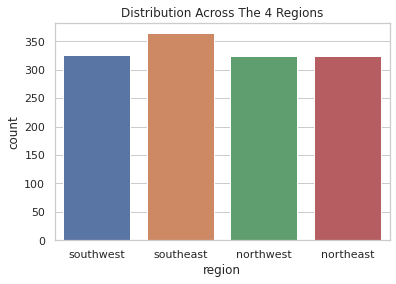

In [979]:
#Check the distribution across the four regions.
sns.countplot(x='region',data=df);
plt.title("Distribution Across The 4 Regions");

There distribution is almost the same between the 4 regions with southeast having slightly more people.

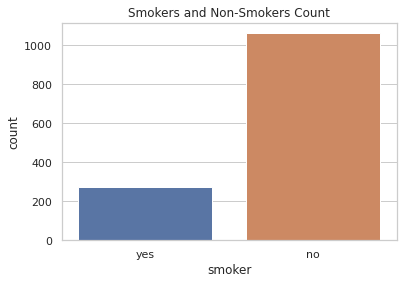

In [980]:
#check for population of smokers to non smokers in the data
sns.countplot(data=df,x='smoker')
plt.title('Smokers and Non-Smokers Count');

Our data has more non-smokers than smokers.

**Examine the distribution of Bmi (Body Mass Index)**

In [981]:
#Calculate Skew for bmi.
print(f'BMI has a skew of {round(df["bmi"].skew(), 2)}.')

BMI has a skew of 0.28.


We have a skew that is between 0.5 and -0.5. Hence our distribution can be considered normal.

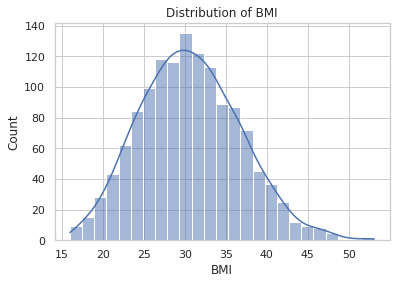

In [982]:
sns.histplot(x=df['bmi'],kde=True)
plt.xlabel("BMI")
plt.ylabel("Count")
plt.title("Distribution of BMI");

The histogram just confirms normal distribution.

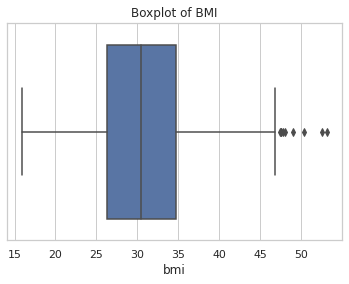

In [983]:
#Checking for outliers in bmi
sns.boxplot(x=df['bmi'])
plt.title("Boxplot of BMI");

We have outliers in our bmi column. This can greatly affect our regresion models.Outliers can lead to bad estimation. We will have to perform scaling or transformation to remove them.

In [984]:
#More descriptive analysis
df['bmi'].describe()

count    1337.000000
mean       30.663452
std         6.100468
min        15.960000
25%        26.290000
50%        30.400000
75%        34.700000
max        53.130000
Name: bmi, dtype: float64

**Examine the relationship between “smoker” and “charges”**

In [985]:
#Check number of smokers and non-smokers
df['smoker'].value_counts()

no     1063
yes     274
Name: smoker, dtype: int64

The data consists of more non-smokers that smokers.

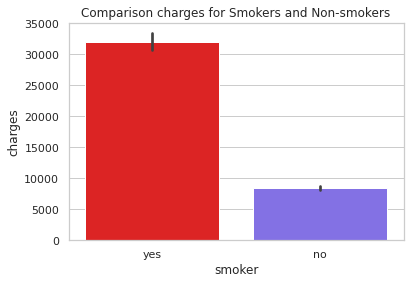

In [986]:
sns.barplot(data=df,x='smoker',y='charges',palette=['#fb0505','#765ef7'])
plt.title("Comparison charges for Smokers and Non-smokers");

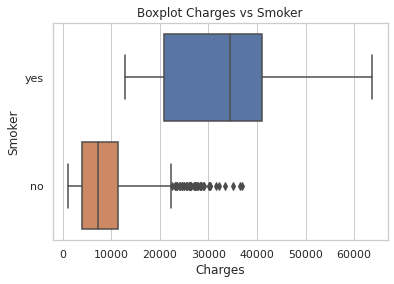

In [987]:
sns.boxplot(y='smoker', x='charges',data=df)
plt.xlabel("Charges")
plt.ylabel('Smoker')
plt.title("Boxplot Charges vs Smoker");

In [988]:
mean_smoker = df[df["smoker"] == 'yes']['charges'].mean().round(2)
mean_non_smoker = df[df["smoker"] == 'no']['charges'].mean().round(2)
print(f"A smoker pays an average of {mean_smoker}, while a non-smoker pays an average of {mean_non_smoker}.")

A smoker pays an average of 32050.23, while a non-smoker pays an average of 8440.66.


Smokers are charged more premium that non-smokers as it is expected.

**Examine the relationship between “smoker” and “region”.**


In [989]:
#Different regions
df['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [990]:
df['region'].describe()

count          1337
unique            4
top       southeast
freq            364
Name: region, dtype: object

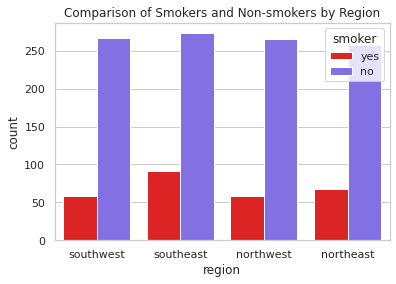

In [991]:
sns.countplot(data=df,x='region',hue='smoker',palette=['#fb0505','#765ef7'])
plt.title("Comparison of Smokers and Non-smokers by Region");

Southeast region has the highest number of smokers and also highest number of non-smokers. This could be because it has a higher population than the other regions.

**Examine the relationship between “bmi” and “sex”.**

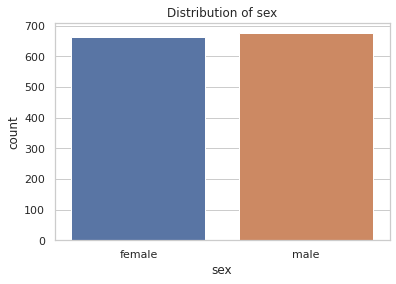

In [992]:
#Check for count according to sex
sns.countplot(data=df,x='sex')
plt.title('Distribution of sex');

The female and male sex are fairly distributed.

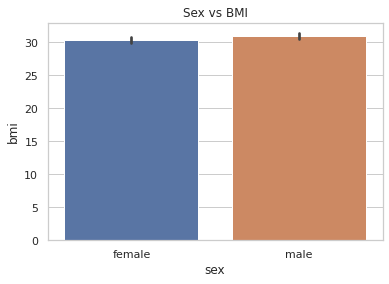

In [993]:
sns.barplot(data=df,x='sex',y='bmi')
plt.title('Sex vs BMI');

In [994]:
male_bmi = df[df['sex'] == 'male']['bmi'].mean()
female_bmi = df[df['sex'] == 'female']['bmi'].mean()
print(f'The average bmi for males is {round(male_bmi, 2)} and for females is {round(female_bmi, 2)}.')

The average bmi for males is 30.94 and for females is 30.38.


The Average BMI for both male and female is around 30.

**Find the "region" with the most "children".**

In [995]:
#Number of chilren in each region
df_child = df.groupby('region')['children'].sum()
df_child

region
northeast    339
northwest    373
southeast    382
southwest    371
Name: children, dtype: int64

In [996]:
df_child = pd.DataFrame({'region':df_child.index, 'child_count':df_child.values})

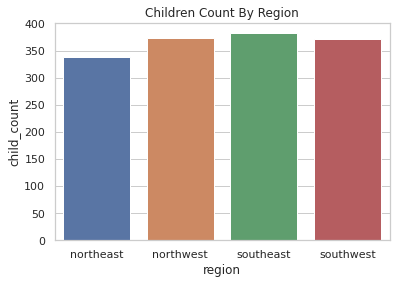

In [997]:
plt.xlabel('Region')
plt.ylabel('Total Children Count')
plt.title('Children Count By Region')
sns.barplot(data=df_child,x='region',y='child_count');

Southeast region has the highest number of children. Which is not surprising as it has the highest population of the four regions.

**Examine the relationship between “age” and “bmi”.**

Age has a skew of 0.05


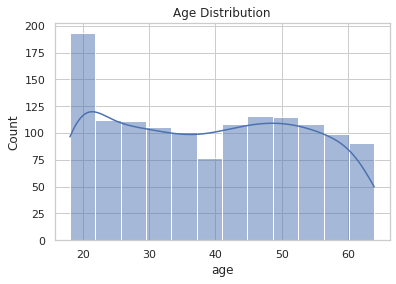

In [998]:
#Age disribution and skew
age_skew = df['age'].skew()
sns.histplot(df['age'],kde=True)
plt.title('Age Distribution');
print(f'Age has a skew of {round(age_skew,2)}')

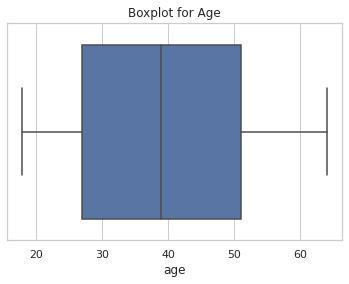

In [999]:
#cheking for outliers
sns.boxplot(x=df['age'])
plt.title('Boxplot for Age');

Age data has no outliers.

In [1000]:
df[['bmi','age']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bmi     1337 non-null   float64
 1   age     1337 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 63.6 KB


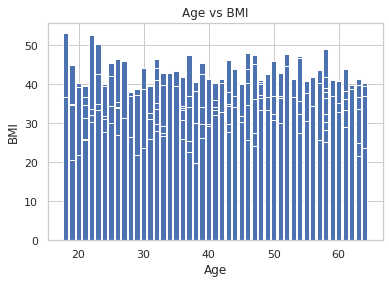

In [1001]:
plt.bar(df['age'],df['bmi'])
plt.ylabel('BMI')
plt.xlabel('Age')
plt.title('Age vs BMI');

There is no relationship between age and bmi.

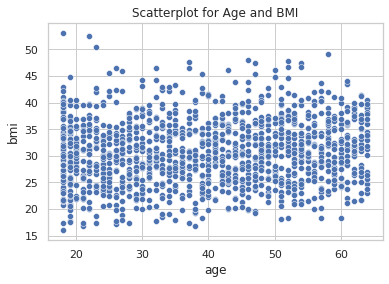

In [1002]:
sns.scatterplot(data=df,y='bmi',x='age')
plt.title('Scatterplot for Age and BMI');

In [1003]:
#Correlation between age and bmi
corr_age_bmi = df['age'].corr(df['bmi']);
print(f'The correlation of age and bmi is {round(corr_age_bmi,2)}.')

The correlation of age and bmi is 0.11.


**Examine the relationship between “bmi” and “children”.**

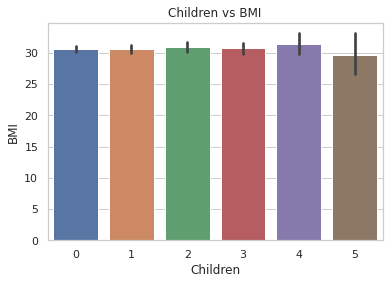

In [1004]:
sns.barplot(data=df,x='children',y='bmi')
plt.xlabel("Children")
plt.ylabel("BMI")
plt.title("Children vs BMI");

In [1005]:
#Correlation between children and bmi
corr_children_bmi = df['children'].corr(df['bmi']);
print(f'The correlation of children and bmi is {round(corr_children_bmi,2)}.')

The correlation of children and bmi is 0.01.


No relationship between chilren and bmi. We can see this from the barplot. The calculation of correlation further proves there is no relationship, as it is close to zero.



**Examine the relationship between “bmi” and “charges”.**

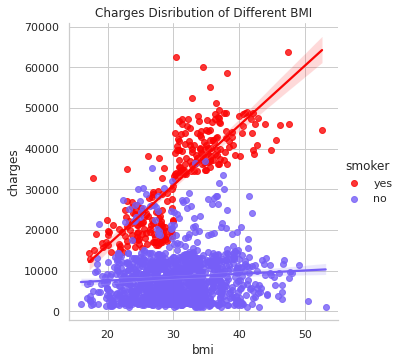

In [1006]:
sns.lmplot(data=df,x='bmi',y='charges',hue='smoker',palette=['#fb0505','#765ef7'])
plt.title("Charges Disribution of Different BMI");

We see the a relationship between bmi and charges. but a dramatically steeper hike for smokers in comparison to non-smokers. We can conclude that smoking significantly raises the premium levels for health insurance.

**Examine the relationship between “region”, “smoker” and “bmi” using bar plot**

In [1007]:
df[(df['region'] == 'southeast') & (df['smoker'] == 'yes') ]['bmi'].mean()

33.096703296703296

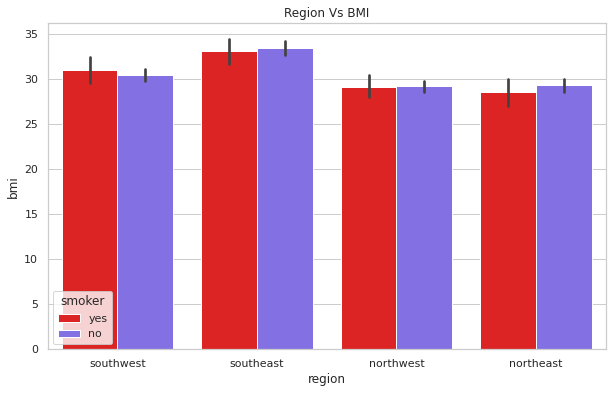

In [1008]:
fig = plt.figure(figsize=(10,6))
sns.barplot(data=df,x='region',y='bmi',hue='smoker',palette=['#fb0505','#765ef7'])
plt.title("Region Vs BMI");

The average bmi for smokers against non- smokers is almost the same across the 4 regions.

*   Non-smokers have a higher bmi across the 4 regions except for southwest. 
*   Southeast region has the highest bmi for both smokers and non smokers.
*   Northwest region has the lowest bmi for both smokers and non smokers.
*   Southwest has slightly higher bmi for smokers than non-smokers.



### **Further EDA**

In [1009]:
#Creating
df_copy = df.copy()

In [1010]:
# With children and smokers
df_copy['has_children'] = df_copy['children'] > 0
df_copy.head()

,age,sex,bmi,children,smoker,region,charges,has_children
0,19,female,27.900,0,yes,southwest,16884.92400,False
1,18,male,33.770,1,no,southeast,1725.55230,True
2,28,male,33.000,3,no,southeast,4449.46200,True
3,33,male,22.705,0,no,northwest,21984.47061,False
4,32,male,28.880,0,no,northwest,3866.85520,False


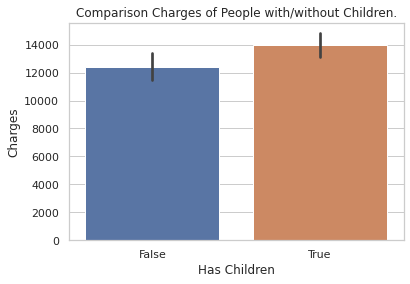

In [1011]:
sns.barplot(data=df_copy,x='has_children',y='charges');
plt.xlabel('Has Children')
plt.ylabel('Charges')
plt.title('Comparison Charges of People with/without Children.');

People with children on average pay slightly more than those people without children.

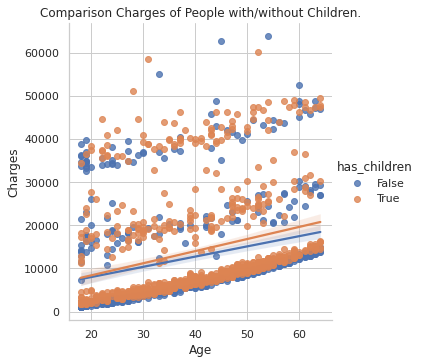

In [1012]:
sns.lmplot(data=df_copy,x='age',y='charges',hue='has_children')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.title('Comparison Charges of People with/without Children.');

In [1013]:
#check for those considered obese.
df_copy['considered_obese'] = df_copy['bmi'] > 30.0
df_copy.head()

,age,sex,bmi,children,smoker,region,charges,has_children,considered_obese
0,19,female,27.900,0,yes,southwest,16884.92400,False,False
1,18,male,33.770,1,no,southeast,1725.55230,True,True
2,28,male,33.000,3,no,southeast,4449.46200,True,True
3,33,male,22.705,0,no,northwest,21984.47061,False,False
4,32,male,28.880,0,no,northwest,3866.85520,False,False


People with a BMI greater that 30.0 are considered obese.

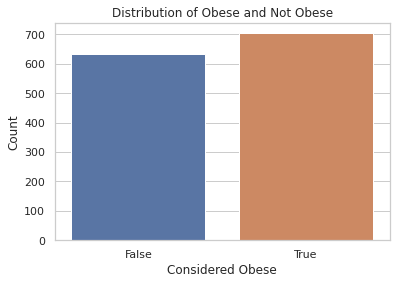

In [1014]:
sns.countplot(data=df_copy,x='considered_obese');
plt.xlabel('Considered Obese')
plt.ylabel('Count')
plt.title('Distribution of Obese and Not Obese');

In [1015]:
pct_obese = ((len(df_copy[df_copy['considered_obese'] == True]) / len(df_copy)) * 100)
print(f'The percentage of obese people in the population is {round(pct_obese,2)}%')

The percentage of obese people in the population is 52.66%


Slightly more than half the population is considered obese.

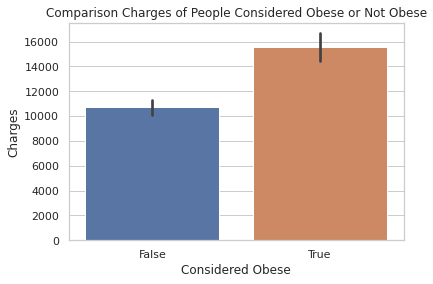

In [1016]:
sns.barplot(data=df_copy,x='considered_obese',y='charges');
plt.xlabel('Considered Obese')
plt.ylabel('Charges')
plt.title('Comparison Charges of People Considered Obese or Not Obese');

In [1017]:
considered_obese_smoker = df_copy[(df_copy['considered_obese'] == True) & (df_copy['smoker'] == 'yes')]
considered_obese_non_smoker = df_copy[(df_copy['considered_obese'] == True) & (df_copy['smoker'] == 'no')]

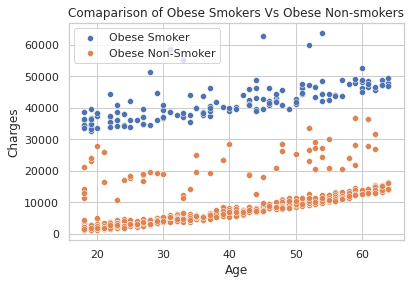

In [1018]:
sns.scatterplot(x = 'age', y = 'charges', data = considered_obese_smoker, label = 'Obese Smoker')
sns.scatterplot(x = 'age', y = 'charges', data = considered_obese_non_smoker, label = 'Obese Non-Smoker')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.title('Comaparison of Obese Smokers Vs Obese Non-smokers');

Obese smokers pay a very high premium comapred to obese non-smokers.

In [1019]:
#check for how people of different ages pay premium.
mask = [
    (df_copy['age'] < 36),
    (df_copy['age'] >=36 ) & (df_copy['age'] < 55),
    (df_copy['age'] >= 55),
    ]
values = ['young-adult','middle-aged','senior']

df_copy['age_group'] = np.select(mask,values)
df_copy.tail()

,age,sex,bmi,children,smoker,region,charges,has_children,considered_obese,age_group
1333,50,male,30.97,3,no,northwest,10600.5483,True,True,middle-aged
1334,18,female,31.92,0,no,northeast,2205.9808,False,True,young-adult
1335,18,female,36.85,0,no,southeast,1629.8335,False,True,young-adult
1336,21,female,25.80,0,no,southwest,2007.9450,False,False,young-adult
1337,61,female,29.07,0,yes,northwest,29141.3603,False,False,senior


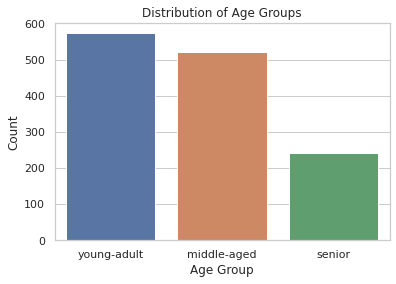

In [1020]:
sns.countplot(data=df_copy,x='age_group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Distribution of Age Groups');

As expected from any population, the young adults are more, followed by the middle-aged then the least are senior citizens.

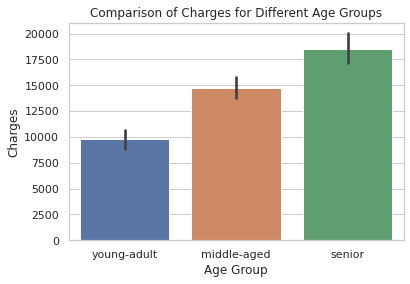

In [1021]:
sns.barplot(data=df_copy,x='age_group',y='charges')
plt.xlabel('Age Group')
plt.ylabel('Charges')
plt.title('Comparison of Charges for Different Age Groups');

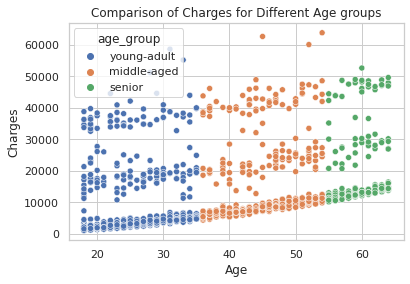

In [1022]:
sns.scatterplot(data=df_copy,x='age',y='charges',hue='age_group')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.title('Comparison of Charges for Different Age groups');

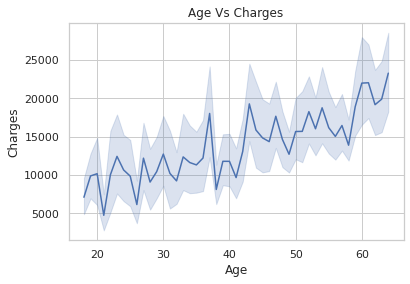

In [1023]:
sns.lineplot(data=df_copy,x='age',y='charges')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.title('Age Vs Charges');

From the visualizations above we can clearly see there is a general increasing trend of charges as age increases.

In [1024]:
seniors = df_copy[df_copy['age_group'] == 'senior']['charges'].mean()
young_adults = df_copy[df_copy['age_group'] == 'young-adult']['charges'].mean()
middle_aged = df_copy[df_copy['age_group'] == 'middle-aged']['charges'].mean()
print(
f'Seniors pay an average of {round(seniors, 2)} \
compared to {round(young_adults, 2)} \
of young adults and {round(middle_aged, 2)} of middle-aged.'
)

Seniors pay an average of 18513.28 compared to 9758.62 of young adults and 14717.01 of middle-aged.


On Average senior citizens pay more premiums than other age groups. This reflects the higher health care costs expected for older people. We can see that as age increases so does the premium.

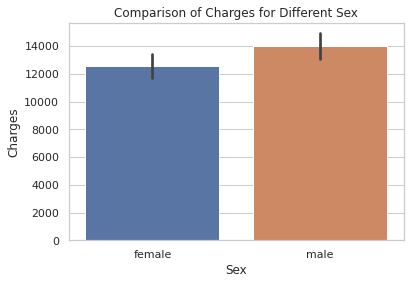

In [1025]:
#comparison of charges by sex
sns.barplot(data=df_copy,x='sex',y='charges')
plt.xlabel('Sex')
plt.ylabel('Charges')
plt.title('Comparison of Charges for Different Sex');

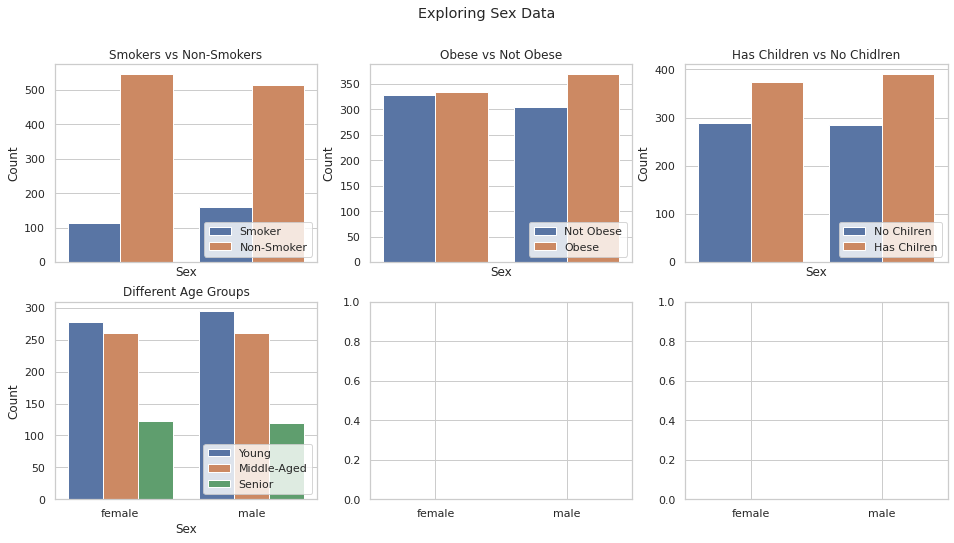

In [1026]:
fig, axes = plt.subplots(2, 3, sharex=True, figsize=(16,8))
fig.suptitle('Exploring Sex Data')
sns.countplot(ax=axes[0,0],data=df_copy,x='sex',hue="smoker")
axes[0,0].set_xlabel('Sex')
axes[0,0].set_ylabel('Count')
axes[0,0].legend(['Smoker','Non-Smoker'],loc='lower right')
axes[0,0].set_title('Smokers vs Non-Smokers')
sns.countplot(ax=axes[0,1],data=df_copy,x='sex',hue="considered_obese")
axes[0,1].set_xlabel('Sex')
axes[0,1].set_ylabel('Count')
axes[0,1].legend(['Not Obese','Obese'],loc='lower right')
axes[0,1].set_title('Obese vs Not Obese')
sns.countplot(ax=axes[0,2],data=df_copy,x='sex',hue="has_children")
axes[0,2].set_xlabel('Sex')
axes[0,2].set_ylabel('Count')
axes[0,2].legend(['No Chilren','Has Chilren',],loc='lower right')
axes[0,2].set_title('Has Children vs No Chidlren')
sns.countplot(ax=axes[1,0],data=df_copy,x='sex',hue="age_group")
axes[1,0].set_xlabel('Sex')
axes[1,0].set_ylabel('Count')
axes[1,0].legend(['Young','Middle-Aged','Senior'],loc='lower right')
axes[1,0].set_title('Different Age Groups');

From the data and visualizations we can see that male pay a higher premium that female counterparts. And this is bacause more males are smokers than females, more males are obese than females and more males have children than females.

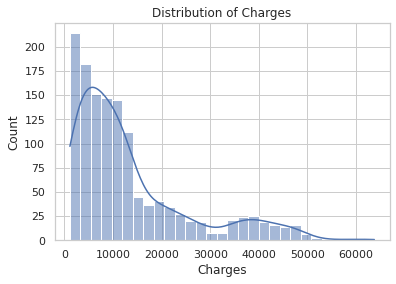

In [1027]:
#Looking at the charges distribution.
sns.histplot(df_copy['charges'],kde=True)
plt.xlabel('Charges')
plt.title("Distribution of Charges");

In [1028]:
charges_skew = df_copy['charges'].skew()
print(f'Charges data has a skew of {round(charges_skew, 4)}.')

Charges data has a skew of 1.5154.


We can see that the target right-skewed and not normally distributed.

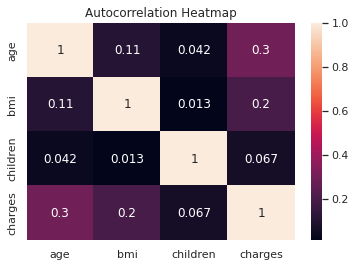

In [1029]:
#Check for Multicollinearity in our numerical data.
corr = df.select_dtypes('number').corr()
sns.heatmap(corr,annot=True)
plt.title('Autocorrelation Heatmap');

We can see that age and bmi have a slight correlation to charges.

## **Split**

### **Preprossesing**

In [1030]:
#Creating Feature Matrix (X) and Target Vector (y)
X = df.drop(columns='charges')
y = df['charges']

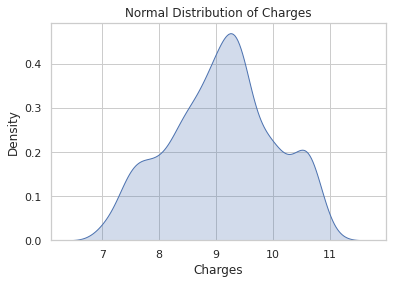

In [1031]:
#Perform log transformation on y since it is skewed.
y_transformed = np.log(y)
sns.kdeplot(y_log,shade=True)
plt.title('Normal Distribution of Charges')
plt.xlabel('Charges');

In [1032]:
#Outliers in our bmi column
#Inter quartile range (IQR) method
#We see that we have outliers on the upper end of our data.
Q1 = X['bmi'].quantile(0.25)
Q3 = X['bmi'].quantile(0.75)
IQR=Q3-Q1
#Check the outliers in our data
X[(X['bmi']>(Q3+1.5*IQR))]

,age,sex,bmi,children,smoker,region
116,58,male,49.06,0,no,southeast
286,46,female,48.07,2,no,northeast
401,47,male,47.52,1,no,southeast
543,54,female,47.41,0,yes,southeast
847,23,male,50.38,1,no,southeast
860,37,female,47.60,2,yes,southwest
1047,22,male,52.58,1,yes,southeast
1088,52,male,47.74,1,no,southeast
1317,18,male,53.13,0,no,southeast


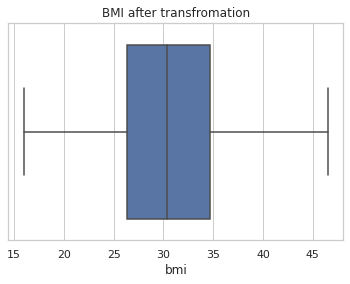

In [1033]:
#We do winsoring to our bmi data to transform outliers.
X['bmi'] = winsorize(df['bmi'], limits=[0.0, 0.01])
sns.boxplot(x=X['bmi'])
plt.title('BMI after transfromation');

In [1034]:
#We perform scaling on our bmi data.
ss = StandardScaler()
X['bmi'] =  ss.fit_transform(X['bmi'].values.reshape(-1, 1))
X.head()

,age,sex,bmi,children,smoker,region
0,19,female,-0.454235,0,yes,southwest
1,18,male,0.517233,1,no,southeast
2,28,male,0.389800,3,no,southeast
3,33,male,-1.313992,0,no,northwest
4,32,male,-0.292048,0,no,northwest


In [1035]:
#Encode Sex and Smoke column using label encoder.
X.head()
le = LabelEncoder()
X['sex'] = le.fit_transform(X['sex'])
X['smoker'] = le.fit_transform(X['smoker'])
X.head()

,age,sex,bmi,children,smoker,region
0,19,0,-0.454235,0,1,southwest
1,18,1,0.517233,1,0,southeast
2,28,1,0.389800,3,0,southeast
3,33,1,-1.313992,0,0,northwest
4,32,1,-0.292048,0,0,northwest


In [1036]:
#Encode features in X using OneHotEncoder.
#This will only ecode region as it is the only categorical data left.
ohe = OneHotEncoder(use_cat_names=True)
X_transformed = ohe.fit_transform(X)
X_transformed.head()

,age,sex,bmi,children,smoker,region_southwest,region_southeast,region_northwest,region_northeast
0,19,0,-0.454235,0,1,1,0,0,0
1,18,1,0.517233,1,0,0,1,0,0
2,28,1,0.389800,3,0,0,1,0,0
3,33,1,-1.313992,0,0,0,0,1,0
4,32,1,-0.292048,0,0,0,0,1,0


In [1037]:
X_train,X_test,y_train,y_test = train_test_split(X_transformed,y_transformed,test_size=0.2,random_state=42)

# **Build Model**

In [1038]:
def model_predictions_plot(test,pred):
  """
  Plots the predictions and true values.
  """
  x_ax = range(len(test))
  fig = plt.figure(figsize=(20,5))
  sns.lineplot(x=x_ax, y=test, label="true")
  sns.lineplot(x=x_ax, y=pred, label="predicted")
  plt.title("True and Predicted Charges")
  plt.ylabel('Charges')
  plt.xlabel('Count')
  plt.legend()
  plt.show()

def model_evaluation(pred_train, pred_test):
  print("Train R Squared:",round(r2_score(y_train, pred_train), 4))
  print("Test R Squared:",round(r2_score(y_test, pred_test), 4))

def plot_feature_importances(feature_importances):
  sns.barplot(data=feature_importances.head(),x='value',y='feature',color="b")
  plt.title('Model Feature Importances')
  plt.xlabel('Values')
  plt.ylabel('Feature');


## **Baseline model**

In [1039]:
#We create a baseline model that always predicts the mean.
#This helps us compare how the models we train perform against a baseline model.
#This are the evaluations to beat during model training.
y_mean = y_train.mean()
y_pred = [y_mean] * len(y_train)

print("R Squared:",r2_score(y_train, y_pred))
print("MSE:",mean_squared_error(y_train, y_pred))
print("MAE:",mean_absolute_error(y_train, y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_train, y_pred)))

R Squared: 0.0
MSE: 0.821770753337833
MAE: 0.7328344027188818
RMSE: 0.9065157215061596


## **Iterate**

In [1040]:
#List of  regression models. 
reg_models = [
    LinearRegression(),
    Lasso(),
    Ridge(),
    SVR(kernel = 'linear'),
    DecisionTreeRegressor(),
    BaggingRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor(objective='reg:squarederror'),#Added objective to remove deprecation warning.
    LGBMRegressor(),
    AdaBoostRegressor(),
    KNeighborsRegressor()
]

In [1041]:
#Fitting models with cross-validation
def iterate_model(model):
  scores = cross_val_score(model, X_transformed, y_transformed, cv=KFold(n_splits=10), scoring='r2')
  r_squared = scores.mean()
  return r_squared


values = {"regressor":[],"r_squared":[]}
for model in reg_models:
  eval = iterate_model(model)
  values['regressor'].append(str(model).split('(')[0])
  values['r_squared'].append(eval)

#DataFrame containing evaluation of trained model.
df_eval = pd.DataFrame(values)
df_eval.sort_values('r_squared', ascending=False)

,regressor,r_squared
7,GradientBoostingRegressor,0.831731
8,XGBRegressor,0.831682
9,LGBMRegressor,0.812743
6,RandomForestRegressor,0.812149
5,BaggingRegressor,0.805553
0,LinearRegression,0.760896
2,Ridge,0.760886
3,SVR,0.741567
10,AdaBoostRegressor,0.740165
4,DecisionTreeRegressor,0.658349


The Gradient Boosting models perform better than other models. The GradientBoostingRegressor performs the best.

## **Hyper-parameter tuning**

### **Using Grid Search**

In [1042]:
def model_grid_search(model,params):
  gs_model = GridSearchCV(model,
                      param_grid=params,
                      scoring='r2',
                      n_jobs=-1,
                      cv=5)
  gs_model.fit(X_train, y_train)
  best_params = gs_model.best_params_
  print(f'The best model params : {best_params}')
  predictions = gs_model.predict(X_test)
  predictions_train = gs_model.predict(X_train)
  model_evaluation(predictions_train,predictions)
  return best_params


In [1043]:
params = {
          'max_depth': range(1,10,1),
          'n_estimators':range(20,200,20),
          'learning_rate':[0.1,0.2,0.3]
          }
          
best_params = model_grid_search(GradientBoostingRegressor(random_state=42),params)

The best model params : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 40}
Train R Squared: 0.8446
Test R Squared: 0.884


# **Evaluation**

We will be evaluating the GradientBoostingRegressor.

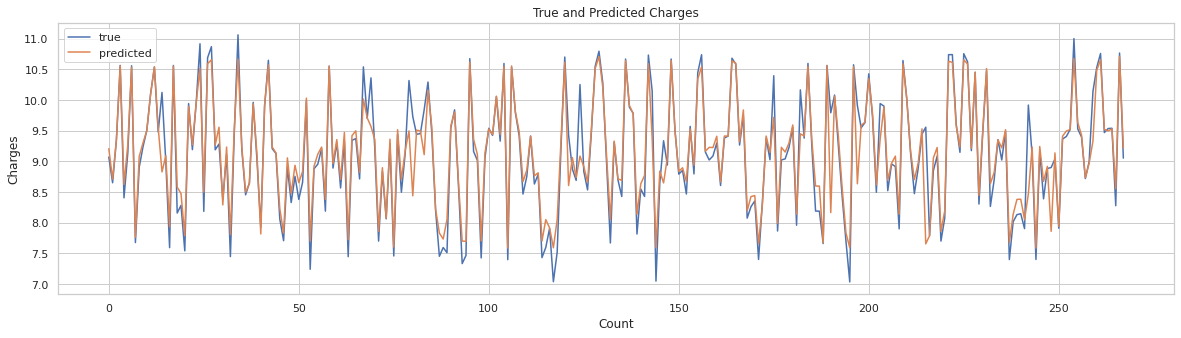

Train R Squared: 0.8446
Test R Squared: 0.884
MSE: 0.10766384189533595
MAE: 0.18440887048101082
RMSE: 0.32812168763331684


In [1044]:
model = GradientBoostingRegressor(
    random_state=42,
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'], 
    n_estimators=best_params['n_estimators']
)
model.fit(X_train,y_train)
y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

model_predictions_plot(y_test,y_pred)
model_evaluation(y_pred_train,y_pred)
print("MSE:",mean_squared_error(y_test, y_pred))
print("MAE:",mean_absolute_error(y_test, y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))

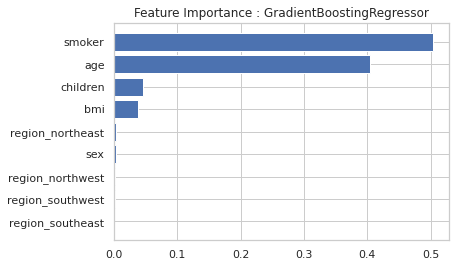

In [1045]:
sorted_idx = gbb.feature_importances_.argsort()
plt.barh(X_transformed.columns[sorted_idx], gbb.feature_importances_[sorted_idx])
plt.title('Feature Importance : GradientBoostingRegressor');

We can see that smoker,age and children are top 3 features that had the most effect on how our GradientBoostingRegressor made predictions.